# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* NHD Plus for river network
* NRCS soils data for soil types
* NLCD for land cover/transpiration/rooting depths
* NED for elevation

In [1]:
%matplotlib inline
# %matplotlib notebook

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [51]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
from matplotlib_scalebar.scalebar import ScaleBar
import shapely
import logging
import fiona
import rasterio
import pickle

import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)

In [49]:
watershed_name = "American"
fname_surface_mesh = "./meshes/{}_surface_mesh.vtk".format(watershed_name)
fname_final_mesh = "./meshes/{}_final_mesh.exo".format(watershed_name)

fig_mesh = "./figures/{}_mesh.png".format(watershed_name)
fig_mesh3D = "./figures/{}_mesh3D.png".format(watershed_name)
fig_soil_type = "./figures/{}_soil_type.png".format(watershed_name)
fig_land_cover = "./figures/{}_land_cover.png".format(watershed_name)
fig_hru = "./figures/{}_HRU.png".format(watershed_name)
fig_DTB = "./figures/{}_DTB.png".format(watershed_name)

fname_mesh_pickle = f'./results/{watershed_name}_mesh.p'

In [4]:
# specify the input shapefile and a hint as to what HUC it is in.
# watershed_shapefile = '../data/hydrologic_units/yakima/yakima_EPSG4269.shp'
watershed_shapefile = '../data/hydrologic_units/yakima/AmericanRiver_EPSG2856.shp'
# watershed_shapefile = '../data/hydrologic_units/yakima/UpperYakima_EPSG4269c.shp'

river_shp = "../data/hydrologic_units/yakima/yakima_river_network.shp"

# fname_hru = "../data/hydrologic_units/Maumee/EC_HRU_reproj.shp"
# fname_soil = "../data/soil/yakima/ssurgo_yakima.shp"
fname_soil = "/Users/shua784/Dropbox/PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/US_soil/gnatsgo_wa_raster/WA_MapunitRaster_10m1.tif"
fname_DTB = "/Users/shua784/Dropbox/PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif"

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [6]:
# hint = '0410'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape


logging.info("")
logging.info("Meshing shape: {}".format(watershed_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = workflow.get_split_form_shapes(watershed_shapefile)
logging.info("watershed CRS: {}".format(crs))

2020-10-27 10:18:20,495 - root - INFO: 
2020-10-27 10:18:20,496 - root - INFO: Meshing shape: ../data/hydrologic_units/yakima/AmericanRiver_EPSG2856.shp
2020-10-27 10:18:20,496 - root - INFO: ==============================
2020-10-27 10:18:20,497 - root - INFO: 
2020-10-27 10:18:20,498 - root - INFO: Preprocessing Shapes
2020-10-27 10:18:20,498 - root - INFO: ------------------------------
2020-10-27 10:18:20,498 - root - INFO: loading file: "../data/hydrologic_units/yakima/AmericanRiver_EPSG2856.shp"
/opt/anaconda3/envs/watershed_workflow/lib/python3.8/site-packages/fiona/collection.py:352: FionaDeprecationWarning: Collection slicing is deprecated and will be disabled in a future version.
  return self.session.__getitem__(item)
2020-10-27 10:18:20,620 - root - INFO: watershed CRS: EPSG:2856


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [7]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
# use 10-m DEM instead
sources['DEM'] = workflow.source_list.dem_sources['NED 1/3 arc-second']
workflow.source_list.log_sources(sources)

2020-10-27 10:18:24,882 - root - INFO: Using sources:
2020-10-27 10:18:24,883 - root - INFO: --------------
2020-10-27 10:18:24,883 - root - INFO: HUC: National Watershed Boundary Dataset (WBD)
2020-10-27 10:18:24,884 - root - INFO: hydrography: National Hydrography Dataset (NHD)
2020-10-27 10:18:24,884 - root - INFO: DEM: National Elevation Dataset (NED); resolution: 1/3 arc-second
2020-10-27 10:18:24,885 - root - INFO: soil type: National Resources Conservation Service Soil Survey (NRCS Soils)
2020-10-27 10:18:24,885 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2020-10-27 10:18:24,885 - root - INFO: soil thickness: None
2020-10-27 10:18:24,886 - root - INFO: meteorology: DayMet 1km


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

## import river shapes

### option1 -- import river shapes

In [94]:
# with fiona.open(river_shp, mode='r') as fid:
#     profile = fid.profile
#     reaches = [r for (i,r) in fid.items()]

Watershed boundary and river must be in the same CRS.

In [8]:
# # convert to destination crs
# native_crs = workflow.crs.from_fiona(profile['crs'])
# if crs and not workflow.crs.equal(crs, native_crs):
#     for reach in reaches:
#         workflow.warp.shape(reach, native_crs, crs)
# else:
#     crs = native_crs

**convert to shapely, and merge multiple reach segments into single rivers**

In [ ]:
# reaches_s = [workflow.utils.shply(reach) for reach in reaches]
# # rivers_s = list([shapely.ops.linemerge(shapely.geometry.MultiLineString(reaches_s))])

# rivers = workflow.simplify_and_prune(watershed, reaches_s, filter=False, simplify=30, cut_intersections=False)

In [ ]:
# logging.info("Generate the river tree")
# rivers = workflow.hydrography.make_global_tree(rivers_s)

### Option 2--download river hydrography from NHD

In [ ]:
# # find what HUC our shape is in
# huc = workflow.find_huc(sources['HUC'], watershed.exterior(), crs, hint = '1703', shrink_factor=0.1)
# logging.info("Found watershed in HUC: {}".format(huc))

In [24]:
# sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']

In [42]:
huc = "17030002" # provide the HUC8 for NHD or HUC4 for NHDPlus that includes that watershed
simplify = 30 # length scale to target average edge

rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs,
                                     cvrt = True)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, cut_intersections=True)

else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)



2020-10-27 14:34:04,025 - root - INFO: 
2020-10-27 14:34:04,025 - root - INFO: Preprocessing Hydrography
2020-10-27 14:34:04,026 - root - INFO: ------------------------------
2020-10-27 14:34:04,026 - root - INFO: Loading streams in HUC 17030002
2020-10-27 14:34:04,027 - root - INFO:          and/or bounds (422044.9579910975, 164670.50734242608, 449125.96042868716, 184763.42768634777)
2020-10-27 14:34:04,028 - root - INFO: Using Hydrography file "/Users/shua784/Dropbox/github/watershed-workflow/examples/data/hydrography/NHD_H_17030002_GDB/NHD_H_17030002.gdb"
2020-10-27 14:34:04,433 - root - INFO:   found 1288 reaches
2020-10-27 14:34:04,434 - root - INFO: convert to destination crs : EPSG:2856
2020-10-27 14:39:13,062 - root - INFO: out crs: EPSG:2856
2020-10-27 14:39:13,063 - root - INFO: convert to 1288 shapely files
2020-10-27 14:39:13,101 - root - INFO: merge all shapely branched lines into a single line
2020-10-27 14:39:13,117 - root - INFO: 
2020-10-27 14:39:13,118 - root - INFO: 

### plot watershed bnd and river networks

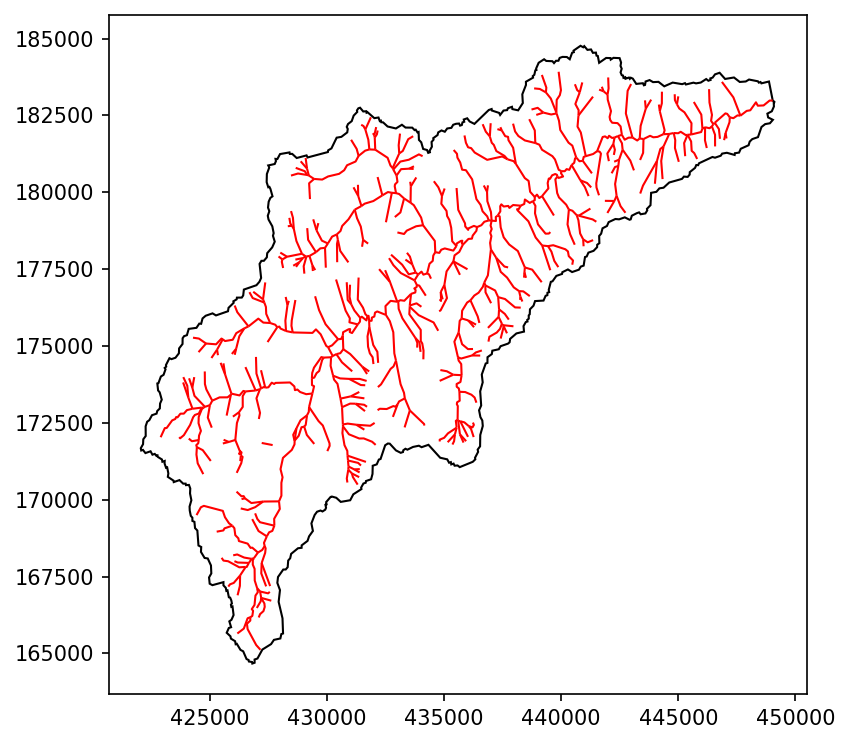

In [43]:
# plot what we have so far -- an image of the HUC and its stream network
fig,ax = plt.subplots(1,1, figsize=(6,6))
# ax = workflow.plot.get_ax(crs, fig)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

2020-10-27 14:41:28,125 - root - INFO: 
2020-10-27 14:41:28,126 - root - INFO: Meshing
2020-10-27 14:41:28,127 - root - INFO: ------------------------------
2020-10-27 14:41:28,130 - root - INFO: Triangulating...
2020-10-27 14:41:28,152 - root - INFO:    1633 points and 1635 facets
2020-10-27 14:41:28,153 - root - INFO:  checking graph consistency
2020-10-27 14:41:28,153 - root - INFO:  tolerance is set to 1
2020-10-27 14:41:28,162 - root - INFO:  building graph data structures
2020-10-27 14:41:28,173 - root - INFO:  triangle.build...
2020-10-27 14:41:28,174 - root - WARNING: Triangulate: '--enforce-delaunay' option requires a hacked `meshpy.triangle`.  Proceeding without this option because it is not recognized.
2020-10-27 14:41:40,699 - root - INFO:   ...built: 12849 mesh points and 25055 triangles
2020-10-27 14:41:40,700 - root - INFO: Plotting triangulation diagnostics
2020-10-27 14:41:43,822 - root - INFO:   min area = 19.182159423828125
2020-10-27 14:41:43,824 - root - INFO:   ma

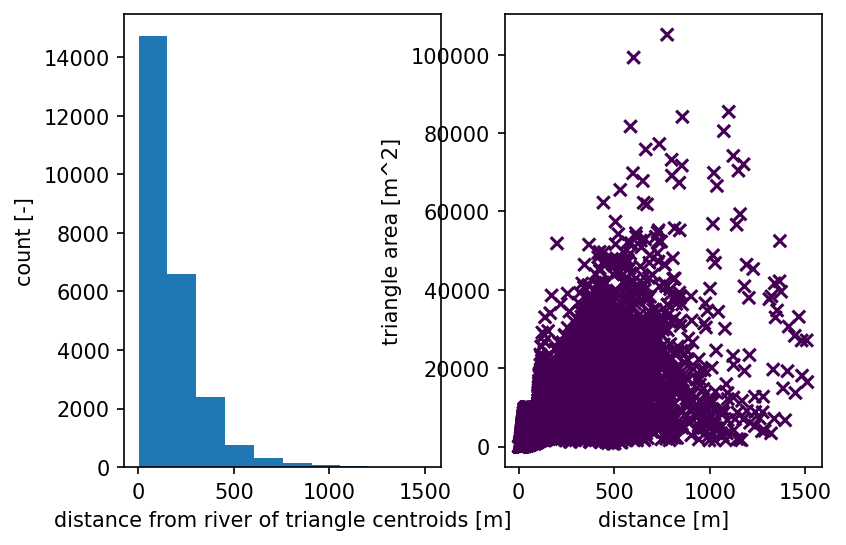

In [44]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 100; d1 = 500
# A0 = 1000; A1 = 5000 # [40, 100]m
A0 = 10000; A1 = 500000 # [100, 1000]m
#A0 = 100; A1 = 500

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, d = workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               enforce_delaunay=True,
                                               diagnostics=True)
#mesh_points2, mesh_tris, d = workflow.triangulate(watershed, rivers,
#                                                 refine_max_area=100000,
#                                                 enforce_delaunay=True,
#                                                 diagnostics=True)

In [52]:
with open(fname_mesh_pickle, 'wb') as f:
    pickle.dump((mesh_points3, mesh_points2, mesh_tris), f, protocol=-1)

## Download DEM

In [45]:
# get a raster for the elevation map, based on NED
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

2020-10-27 14:41:58,977 - root - INFO: 
2020-10-27 14:41:58,978 - root - INFO: Preprocessing Raster
2020-10-27 14:41:58,978 - root - INFO: ------------------------------
2020-10-27 14:41:58,979 - root - INFO: collecting raster
2020-10-27 14:41:59,225 - root - INFO: Collecting DEMs to tile bounds: [-121.53265735527542, 46.80083675067209, -121.15866718696076, 47.002969147236286]
2020-10-27 14:41:59,226 - root - INFO:   Need:
2020-10-27 14:41:59,226 - root - INFO:     /Users/shua784/Dropbox/github/watershed-workflow/examples/data/dem/USGS_NED_13as_n47_w122.img
2020-10-27 14:41:59,227 - root - INFO:     /Users/shua784/Dropbox/github/watershed-workflow/examples/data/dem/USGS_NED_13as_n48_w122.img
2020-10-27 14:41:59,660 - root - INFO: Got raster of shape: (2184, 4040)
2020-10-27 14:41:59,661 - root - INFO: Raster bounds: (-121.53265735527542, 47.002969147236286, -121.15858328147102, 46.800746925159835)


### Map mesh to DEM

In [91]:
# # resample the raster to the triangles
# DEM_mesh = workflow.values_from_raster(m2.centroids(), crs, dem, dem_profile)

In [46]:
# elevate the triangle nodes to the dem
mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile)

2020-10-27 14:42:01,861 - root - INFO: 
2020-10-27 14:42:01,862 - root - INFO: Elevating Triangulation to DEM
2020-10-27 14:42:01,862 - root - INFO: ------------------------------


Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

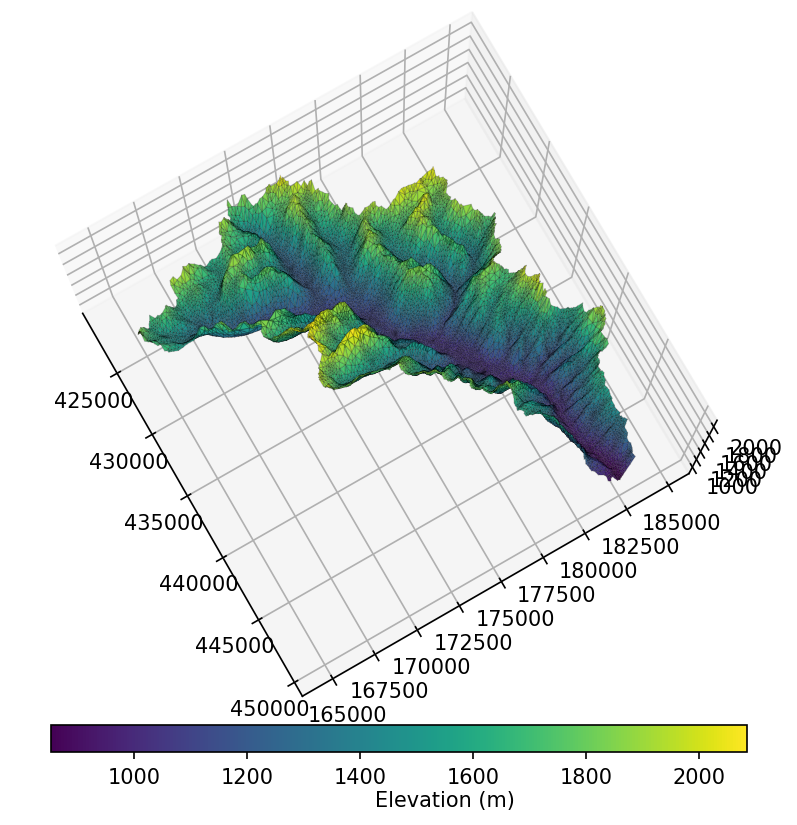

In [23]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

# t = cax.set_title('elevation [m]')
plt.text(0.5, -0.1, 'Elevation (m)', transform=ax.transAxes)

ax.view_init(80,-30)
# ax.set_xticklabels(list())
# ax.set_yticklabels(list())

fig.savefig(fig_mesh3D, dpi = 300, transparent= True)

(420690.9078692189, 450480.0105505666)
(163665.86095, 185768.07405000005)


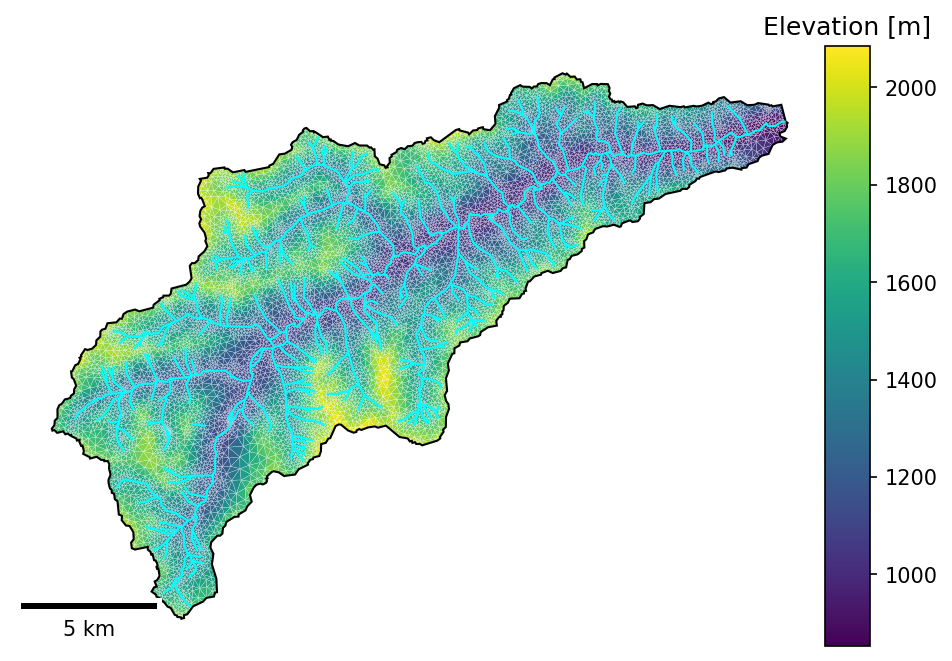

In [24]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(6,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
# ax2 = ax.inset_axes([0.58,0.45,0.3,0.3])
# cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

bxlim = (591000., 600000.)
bylim = (94000., 103000.)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')
# ax.set_xlim([770000, 800000])
# ax.set_ylim([4520000, 4550000])

# mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color='elevation', edgecolor='white', linewidth=0.5)
# workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax2, color='aqua', linewidth=1.5)
# ax2.set_xlim(bxlim)
# ax2.set_ylim(bylim)
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_aspect('equal', 'datalim')

# ax.indicate_inset_zoom(ax2, edgecolor='r')

# ax.margins(0.5)
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
scalebar1 = ScaleBar(1, location = "lower left")
ax.add_artist(scalebar1)
# scalebar2 = ScaleBar(1, location = "upper right")

# ax2.add_artist(scalebar2)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('Elevation [m]')

# fig.tight_layout()
fig.savefig(fig_mesh, dpi = 300, transparent = True)

### construct 2d mesh 

In [25]:
# construct the 2D mesh
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

### Hydrologically condition the mesh

max diff =  27.751773220000814


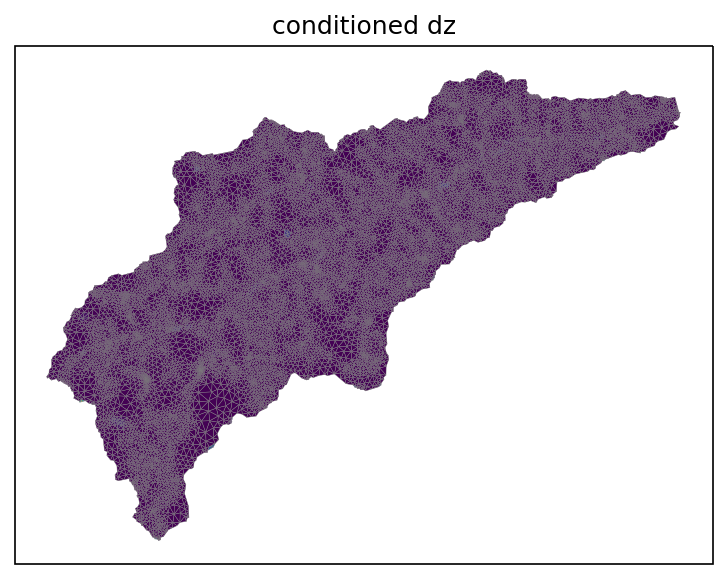

In [26]:
# hydrologically condition the mesh
workflow.condition.condition(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
print("max diff = ", np.abs(diff[:,2]).max())
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
ax.set_title('conditioned dz')
plt.show()

### Export surface mesh

In [27]:
m2.write_VTK(fname_surface_mesh)

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [5]:
m2 = workflow.mesh.Mesh2D.read_VTK(fname_surface_mesh)

In [8]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs,
                                                     raster_crs=crs, 
                                                     mask=False, 
                                                     nodata=-1)

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2020-10-27 10:18:36,621 - root - INFO: 
2020-10-27 10:18:36,622 - root - INFO: Preprocessing Raster
2020-10-27 10:18:36,622 - root - INFO: ------------------------------
2020-10-27 10:18:36,626 - root - INFO: collecting raster
2020-10-27 10:18:36,632 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2020-10-27 10:18:36,778 - root - INFO: Got raster of shape: (1, 542, 972)
2020-10-27 10:18:36,867 - root - INFO: Raster bounds: (4

In [9]:
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

# this is just hacking the label names to make them display a bit neater for a cleaner plot
nlcd_labels_fw = []
for label in nlcd_labels:
    label_fw = label
    if len(label) > 15:
        if ' ' in label:
            lsplit = label.split()
            if len(lsplit) == 2:
                label_fw = '\n'.join(lsplit)
            elif len(lsplit) == 4:
                label_fw = '\n'.join([' '.join(lsplit[0:2]),
                                      ' '.join(lsplit[2:])])
            elif len(lsplit) == 3:
                if len(lsplit[0]) > len(lsplit[-1]):
                    label_fw = '\n'.join([lsplit[0],
                                          ' '.join(lsplit[1:])])
                else:
                    label_fw = '\n'.join([' '.join(lsplit[:-1]),
                                          lsplit[-1]])
    nlcd_labels_fw.append(label_fw)

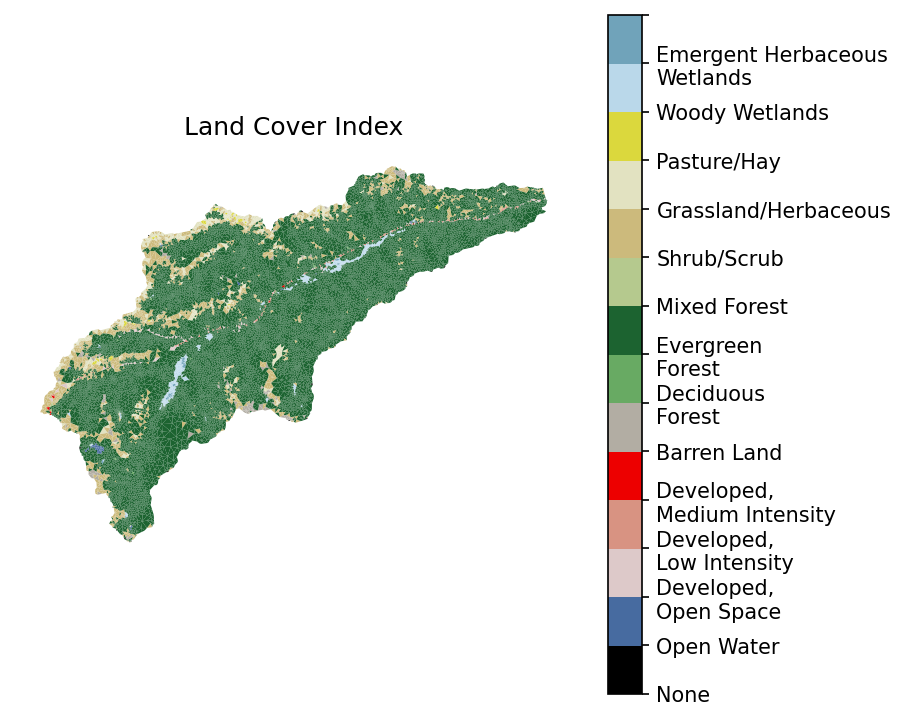

In [10]:
# plot the image
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
mp = pcm.ScalarMappable(norm=nlcd_norm, cmap=nlcd_cmap)
cb = fig.colorbar(mp)
cb.set_ticks(nlcd_ticks)
cb.set_ticklabels(nlcd_labels_fw)
ax.set_title("Land Cover Index")
ax.axis('off')
# fig.tight_layout()
fig.savefig(fig_land_cover, dpi = 300, transparent = True)

## Subsurface properties

### Option 1 -- get soil structure from work flow (not working)

Need to fix the empty crs field in profile to use `workflow.get_shapes()`!

In [30]:
# # download the NRCS soils data as shapes and project it onto the mesh
# import workflow.sources.manager_nrcs
# import matplotlib.cm

# # -- download the shapes
# target_bounds = watershed.exterior().bounds

In [ ]:
# _, soil_survey = workflow.get_shapes(sources['soil type'], target_bounds, crs)

### Option 2 -- import soil data from SSURGO shp

In [ ]:
# _, soil_survey = workflow.get_shapes(fname_soil, target_bounds, crs) 

In [31]:
# with fiona.open(fname_soil, mode='r') as fid:
#     profile = fid.profile
#     soils = [r for (i,r) in fid.items()]

In [ ]:
# # if the profile['crs'] is empty, try manually assign CRS
# if not profile['crs']:
#     profile['crs'] = {'init': 'epsg:5070'}

# # convert to destination crs
# native_crs = workflow.crs.from_fiona(profile['crs'])
# if crs and not workflow.crs.equal(crs, native_crs):
#     for soil in soils:
#         workflow.warp.shape(soil, native_crs, crs)
# else:
#     crs = native_crs

In [ ]:
# soil_survey = [workflow.utils.shply(i) for i in soils]

**map MUKEY to meshes**

In [ ]:
# # -- log the bounds targetted and found
# logging.info('target bounds: {}'.format(target_bounds))
# logging.info('shape union bounds: {}'.format(
#     shapely.ops.cascaded_union(soil_survey).bounds))

In [108]:
# # -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
# #    properties
# soil_ids = np.array([shp.properties['MUKEY'] for shp in soil_survey], np.int32)

In [ ]:
# # -- color a raster by the polygons (this makes identifying a triangle's value much 
# #    more efficient)
# soil_color_raster, soil_color_profile, img_bounds = \
#             workflow.color_raster_from_shapes(target_bounds, target_dx=10, shapes=soil_survey,
#                                               shape_colors=soil_ids, shapes_crs = crs, nodata=-1)

# # -- resample the raster to the triangles
# soil_color = workflow.values_from_raster(m2.centroids(), crs, 
#                                          soil_color_raster, soil_color_profile)

### import soil map from gNATSGO raster

In [11]:
logging.info("import soil raster from {}".format(fname_soil))
with rasterio.open(fname_soil, 'r') as fid:
    soil_profile = fid.profile
    soil_raster = fid.read(1) # read the first band

2020-10-27 10:21:53,951 - root - INFO: import soil raster from /Users/shua784/Dropbox/PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/US_soil/gnatsgo_wa_raster/WA_MapunitRaster_10m1.tif


In [12]:
# resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, soil_raster, soil_profile)

In [14]:
logging.info(f'unique soil MUKEYs:\n {np.array(np.unique(soil_color, return_counts=True)).T}')

2020-10-27 10:22:31,785 - root - INFO: unique soil MUKEYs:
 [[  74155       1]
 [  75318      15]
 [  75322       5]
 [  75327     258]
 [  75328     325]
 [  75334     318]
 [  75339     344]
 [  75340     501]
 [  75342    8207]
 [  75343     134]
 [  75349      27]
 [  75351    1555]
 [  75352    2375]
 [  75356      39]
 [  75357     427]
 [  75359    1162]
 [  75361     541]
 [  75392     709]
 [  75394     213]
 [  75398      17]
 [  75403       5]
 [  75404       3]
 [  75413     406]
 [  75414      82]
 [  75440      20]
 [  75462     150]
 [  75482     240]
 [  75485     186]
 [  75506     287]
 [  75508       8]
 [  75511    1138]
 [  75514     129]
 [  75572     768]
 [  75586     567]
 [  75618     306]
 [  75654     271]
 [  75661     619]
 [  75670     951]
 [  75691     600]
 [  75693      49]
 [  75694     243]
 [  75695     117]
 [  75696     142]
 [ 679189      44]
 [2756441       5]
 [2756442      19]
 [2756450       2]
 [2756451       3]
 [2901078       1]
 [2901079

### plot soil map

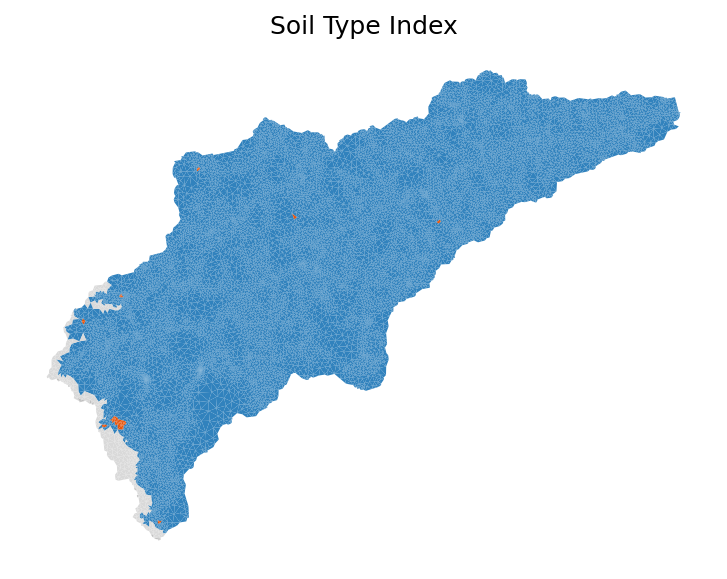

In [56]:
# plot the soil data
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=soil_color, cmap='tab20c')
ax.set_title('Soil Type Index')
ax.axis('off')
# ax.legend()

fig.savefig(fig_soil_type, dpi = 300, transparent = True)

## get bedrock depth

In [15]:
with rasterio.open(fname_DTB, 'r') as fid:
    DTB_profile = fid.profile
    DTB_raster = fid.read(1) # read the first band
    logging.info("imported depth-to-bedrock from {}".format(fname_DTB))

2020-10-27 10:28:42,313 - root - INFO: imported depth-to-bedrock from /Users/shua784/Dropbox/PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif


In [16]:
# resample the raster to the triangles
DTB_mesh = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile)

In [52]:
logging.info(f'minimum depth-to-bedrock: {DTB_mesh.min()} cm')
logging.info(f'maximum depth-to-bedrock: {DTB_mesh.max()} cm')

2020-10-26 15:03:10,586 - root - INFO: minimum depth-to-bedrock: 656 cm
2020-10-26 15:03:10,601 - root - INFO: maximum depth-to-bedrock: 2414 cm


### plot depth to bedrock

In [57]:
DTB_3d = workflow.elevate(mesh_points2, crs, DTB_raster, DTB_profile)

2020-10-27 14:55:55,306 - root - INFO: 
2020-10-27 14:55:55,307 - root - INFO: Elevating Triangulation to DEM
2020-10-27 14:55:55,307 - root - INFO: ------------------------------


(420690.9078692189, 450480.0105505666)
(163665.86095, 185768.07405000005)


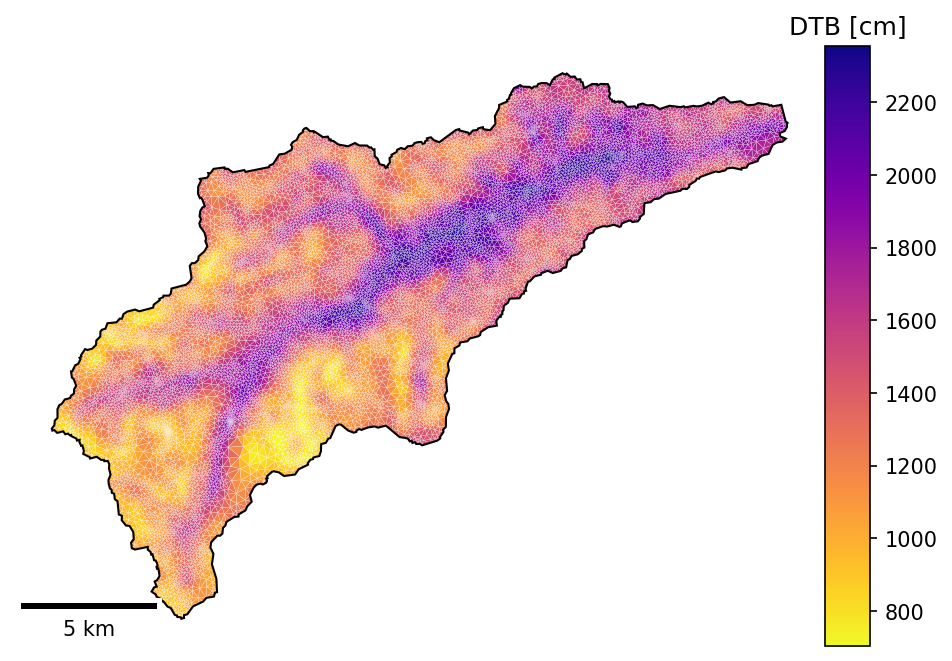

In [74]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(6,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
# ax2 = ax.inset_axes([0.58,0.45,0.3,0.3])
# cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

# bxlim = (591000., 600000.)
# bylim = (94000., 103000.)

mp = workflow.plot.triangulation(DTB_3d, mesh_tris, crs, ax=ax, 
                                 color='elevation', cmap = 'plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')
# ax.set_xlim([770000, 800000])
# ax.set_ylim([4520000, 4550000])

# mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color='elevation', edgecolor='white', linewidth=0.5)
# workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax2, color='aqua', linewidth=1.5)
# ax2.set_xlim(bxlim)
# ax2.set_ylim(bylim)
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_aspect('equal', 'datalim')

# ax.indicate_inset_zoom(ax2, edgecolor='r')

# ax.margins(0.5)
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
scalebar1 = ScaleBar(1, location = "lower left")
ax.add_artist(scalebar1)
# scalebar2 = ScaleBar(1, location = "upper right")

# ax2.add_artist(scalebar2)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('DTB [cm]')

# fig.tight_layout()
fig.savefig(fig_DTB, dpi = 300, transparent = True)

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

In [18]:
total_tckness = np.ceil(DTB_mesh_meter.max())
logging.info(f'total thickness: {total_tckness} m')

2020-10-27 10:31:17,382 - root - INFO: total thickness: 25.0


In [19]:
# ele_per_layer = mesh_tris.shape[0]
ele_per_layer = centr.shape[0]

In [71]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []
z_top = []

z = 0.0
z_top.append(z)
# -- soil layer --
#  top 6 m
#  5 cm initial top cell
#  10 cells
#  expanding dz, growing with depth
ncells = 10
dz = 0.05
layer_dz = 2 # total top thickness

tele = workflow.mesh.telescope_factor(ncells, dz, layer_dz)
logging.info("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_color)
    z += dz
#     dz *= tele
    dz = round(dz * tele, 2)
    z_top.append(z)    

# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
dz = 2.0

geo_ncells = int(np.ceil((total_tckness-z)/dz))
for i in range(geo_ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    ilayer_id = 900 + ncells + i + 1
    layer_mat_ids.append(ilayer_id * np.ones_like(soil_color))
    z += dz    
    z_top.append(z)

2020-10-27 15:20:03,678 - root - INFO: Converged?: ratio = 1.287216430179099, layer z (target = 2) = -1.2583267761101524e-11
2020-10-27 15:20:03,679 - root - INFO: Got telescoping factor: 1.287216430179099


In [72]:
# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2020-10-27 15:20:06,384 - root - INFO: Cell summary:
2020-10-27 15:20:06,385 - root - INFO: ------------------------------------------------------------
2020-10-27 15:20:06,385 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2020-10-27 15:20:06,386 - root - INFO: ------------------------------------------------------------
2020-10-27 15:20:06,386 - root - INFO:  00 	| 00 	| 75340 	|   0.050000 	|   0.000000
2020-10-27 15:20:06,387 - root - INFO:  01 	| 01 	| 75340 	|   0.060000 	|   0.050000
2020-10-27 15:20:06,387 - root - INFO:  02 	| 02 	| 75340 	|   0.080000 	|   0.110000
2020-10-27 15:20:06,388 - root - INFO:  03 	| 03 	| 75340 	|   0.100000 	|   0.190000
2020-10-27 15:20:06,388 - root - INFO:  04 	| 04 	| 75340 	|   0.130000 	|   0.290000
2020-10-27 15:20:06,389 - root - INFO:  05 	| 05 	| 75340 	|   0.170000 	|   0.420000
2020-10-27 15:20:06,389 - root - INFO:  06 	| 06 	| 75340 	|   0.220000 	|   0.590000
2020-10-27 15:20:06,390 - root - INFO:  07 	| 07 	| 75340 	|   0.280000 

### add bedrock material

In [76]:
DTB_mesh_meter = DTB_mesh/100 #convert from cm to m
z_top = np.asarray(z_top)
z_center = z_top[:-1] + (z_top[1:]-z_top[:-1])/2

In [92]:
mat_ids = np.stack(layer_mat_ids)

for icol in np.arange(mat_ids.shape[1])[:]:
#     idem = DEM_mesh[icol]
    idtb = DTB_mesh_meter[icol]
#     ielev = idem - z_center
    idx = z_center > idtb
    
    # assign 9999 to bedrock
    mat_ids[idx, icol] = 9999

In [100]:
layer_mat_ids = [mat_ids[row, :] for row in np.arange(mat_ids.shape[0])]

### extrusion

In [101]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

### add sidesets from land cover type

In [103]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [104]:
# save to disk
try:
    os.remove(fname_final_mesh)
except FileNotFoundError:
    pass
m3.write_exodus(fname_final_mesh)


You are using exodus.py v 1.19.1 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ./meshes/American_final_mesh.exo
Closing exodus file: ./meshes/American_final_mesh.exo
